# Ejercicio 8 - guia 9

Realizar un ajuste usando PyMC de un GLM de la práctica 4. Graficar la posterior de los parámetros. Graficar los datos y el HDI de la posterior predictive.

### Desarrollo

Para este caso decidí ajustar el GLM propuesto en el **[ejercicio 7 de la guía 4](../guia_4/ejercicio_7_guia.ipynb)**. Por lo tanto paso a cargar los datos 
de dicho ejercicio:

In [2]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

ruta_datos_nambe = os.path.join('..', '..','datos', 'raw' ,'nambeware.csv')

df_nambe = pd.read_csv(ruta_datos_nambe, index_col=0)

df_nambe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    59 non-null     object 
 1   Diam    59 non-null     float64
 2   Time    59 non-null     float64
 3   Price   59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB


Hago un gráfico para recordar como se relacionaba la variable objetivo respecto de la predictora:

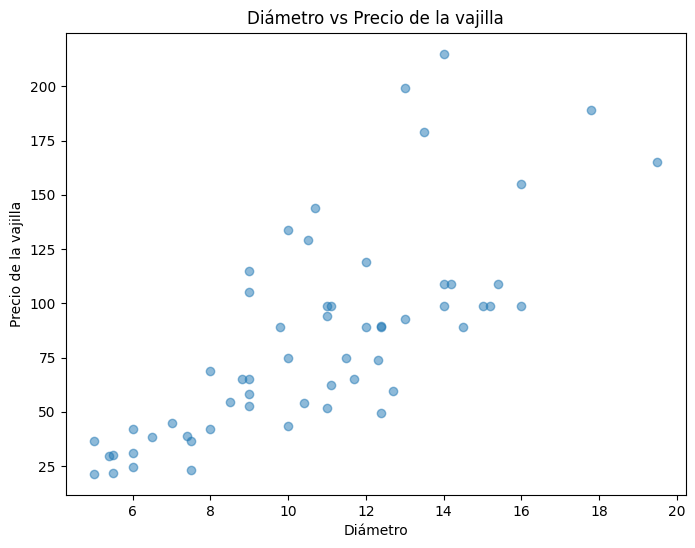

In [3]:
import matplotlib.pyplot as plt


# Elimino outliers
df_nambe = df_nambe[df_nambe['Diam'] < 20]

plt.figure(figsize=(8, 6))
plt.scatter(df_nambe['Diam'], df_nambe['Price'], alpha=0.5)
plt.xlabel('Diámetro')
plt.ylabel('Precio de la vajilla')
plt.title('Diámetro vs Precio de la vajilla')
plt.show()

Paso a ajustar el modelo con PyMC:

In [4]:
import pymc as pm
import numpy as np

X = df_nambe['Diam'].values.flatten()
Y = df_nambe['Price'].values.flatten()

# Estandarizo a X para ayudar al algoritmo a converger más rápido
X_estandarizado = (X - np.mean(X)) / np.std(X)

with pm.Model() as modelo_nambe:

    # Defino distribuciones de los priors
    B0 = pm.Normal('B0', mu=0, sigma=10)
    B1 = pm.Normal('B1', mu=0, sigma=10)
    alpha = pm.HalfNormal('alpha', sigma=5)
    
    # Armo el mu
    mu = B0 + B1 * X_estandarizado
    
    # Defino la función de enlace
    func_enlace = np.exp(mu)

    # Armo la likelihood
    y_obs = pm.Gamma('y_obs', alpha=alpha, beta=alpha/func_enlace, observed=Y)

    # Obtengo la traza
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


Y ahora paso a apreciar los resultados del modelo:

In [5]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,4.331,0.050,4.233,4.422,0.001,0.001,5162.0,3038.0,1.0
B1,0.466,0.053,0.360,0.559,0.001,0.000,6008.0,2680.0,1.0
alpha,7.376,1.268,4.960,9.719,0.017,0.012,5335.0,3305.0,1.0


<Figure size 800x500 with 0 Axes>

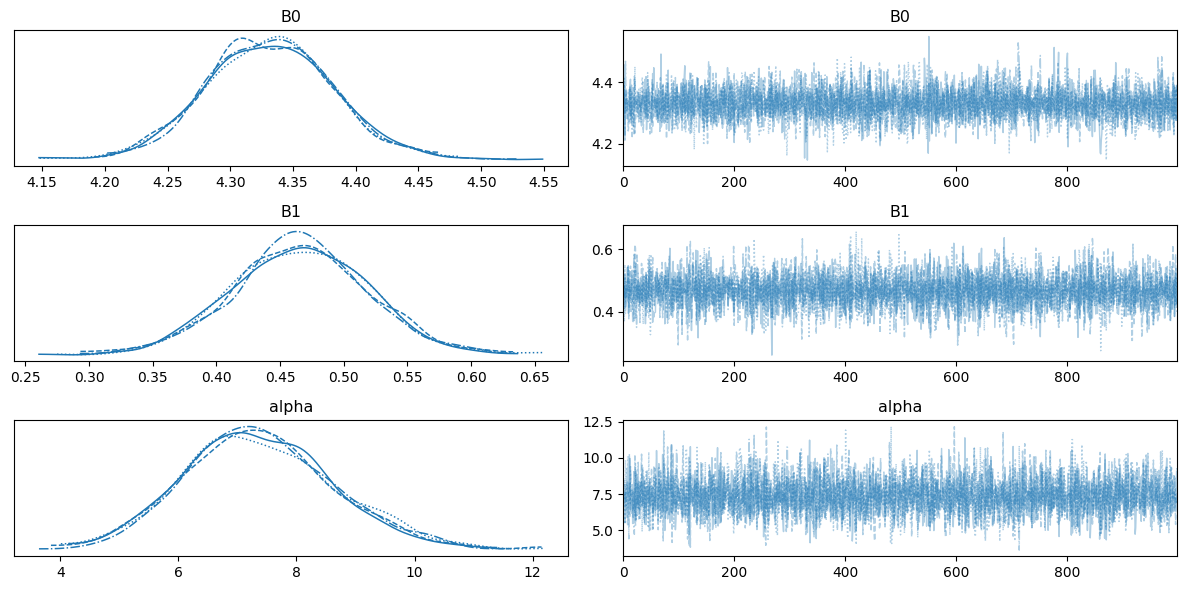

In [6]:
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

Finalmente grafico el 90% HDI de la posterior predictive:

Sampling: [B0, B1, alpha, y_obs]
Sampling: [y_obs]


Output()

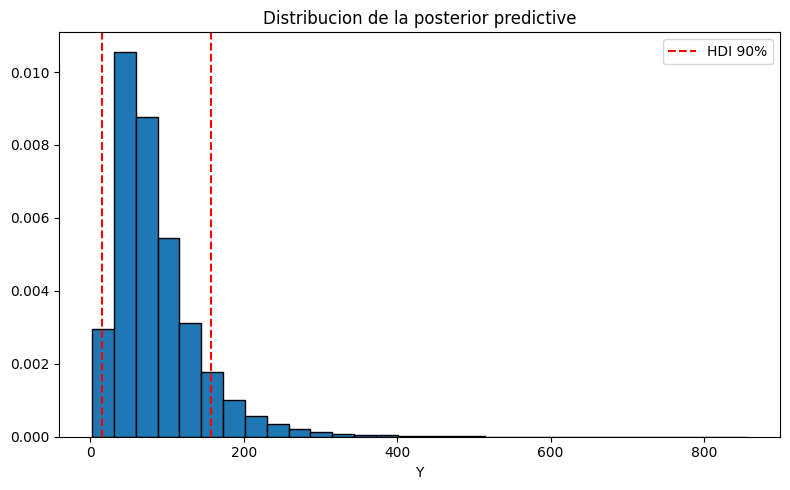

In [7]:
import arviz as az

with modelo_nambe:
    trace.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
estimaciones_y = trace.posterior_predictive['y_obs'].values.flatten()
hdi_90_y = az.hdi(estimaciones_y, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(estimaciones_y, bins=30, density=True, edgecolor='black')
plt.title('Distribucion de la posterior predictive')
plt.axvline(hdi_90_y[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_y[1], color='red', linestyle='--')
plt.xlabel('Y')
plt.legend()
plt.tight_layout()
plt.show()